#### <left>Бронников Максим Андреевич</left>

*M8О-307Б, №4 по списку*

#   <center>Лабораторная работа №4</center>
### <center> Задание №1 </center>

**Реализовать методы Эйлера, Рунге-Кутты и Адамса 4-го порядка в виде программ, задавая в качестве входных данных шаг сетки $h$. С использованием разработанного программного обеспечения решить *задачу Коши* для ОДУ 2-го порядка на указанном отрезке.**

**Оценить погрешность численного решения с использованием метода Рунге – Ромберга и путем сравнения с точным решением.**

### <center> Вариант №4 </center>

**Задача Коши:** 

$$
\begin{equation*}
 \begin{cases}
   x^{2}y'' - x(x^2 - 1)y' - (x^{2} + 1)y = 0
   \\
   y(1) = 1 + e^{\frac{1}{2}}
   \\
   y'(1) = 2e^{\frac{1}{2}}  - 1 
 \end{cases}
\end{equation*}
$$

Для $x \in [1, 2]$ с шагом $h = 0.1$

<span style="color:red">**Внимание:** В задании неверно посчитана 2-ая производная. Далее будет использовано правильное значение $y'(1) = -1$ </span>

**Точное решение:**

$$ y = \displaystyle\frac{1 + e^{\frac{x^2}{2}}}{x} $$

## <center> Решение: </center>

### <center> Преобразование функции </center>

Сведём исходную *задачу Коши* 2-го порядка к системе 1-го порядка:

$$
\begin{equation*}
 \begin{cases}
   y' = z
   \\
   z' = \displaystyle\frac{x(x^2 - 1)z + (x^{2} + 1)y}{x^2}
   \\
   y(1) = 1 + e^{\frac{1}{2}}
   \\
   z(1) = 2e^{\frac{1}{2}}  - 1
 \end{cases}
\end{equation*}
$$

### <center> Вспомогательные функции </center>

Импортируем бибилиотеки:

In [1]:
import matplotlib.pyplot as plt
import math
import sys
import numpy as np
from functools import reduce

Функция $ y = \displaystyle\frac{1 + e^{\frac{x^2}{2}}}{x} $

In [2]:
def y_x(x):
    return (math.exp(x*x / 2) + 1) / x

Функция $y' = e^{\frac{x^2}{2}} - \displaystyle\frac{e^{\frac{x^2}{2}} + 1}{x^2}$

In [3]:
def dy_dx_x(x):
        return math.exp(x*x / 2) - y_x(x)/x

Значение функции $f(x, y, z) = \displaystyle\frac{x(x^2 - 1)z + (x^{2} + 1)y}{x^2}$

In [4]:
def f_xyz(x, y, z):
    return (x*(x*x - 1)*z + (x*x + 1)*y) / (x*x)

Функция, вычисляющая абсолютную погрешность $\| y - \overline{y} \|$ решения $y = y(x)$ задачи Коши приближением $\overline{y}$ в узловых точках:

In [5]:
def epsilon(x, y):
    norm = 0.0
    for i in range(len(x)):
        norm += (y[i] - y_x(x[i]))**2
    return norm**0.5

Функция, вычисляющая абсолютную погрешность $\| y' - \overline{y'} \|$ вычисления первой производной $y' = y'(x)$ приближением $\overline{y'}$ в узловых точках:

In [6]:
def d_epsilon(x, y):
    norm = 0.0
    for i in range(len(x)):
        norm += (y[i] - dy_dx_x(x[i]))**2
    return norm**0.5

Функция вычисления вектора $x$ узловых точек на основе границ отрезка $a, \; b$ и длины шага $h$.

In [7]:
def compute_x(a, b, h):
    return list(np.arange(a, b+h, h))

Функция вычисляет многочлен Лагранжа $ L_n(x) = \displaystyle\sum\limits_{i = 0}^n f_n \displaystyle\prod\limits_{j = 0, j \ne n}^n \frac{(x - x_j)}{(x_n - x_j)} $:

In [8]:
# comute order of chislitels
# Multiply elems in order
def Prod(items = None):
    return reduce(lambda x, y: x*y, items)

# Compute order of znamenatels
def comp_order_znam(Xi):
    ans = []
    for item in Xi:
        ans.append(list(map(lambda it: item - it, filter(lambda it: it != item, Xi))))
    return map(lambda o: 1.0 / o, map(Prod, ans))

# Compute coeefs
def comp_coeffs(Xi, Yi):
    return [m*k for m, k in zip(Yi, comp_order_znam(Xi))]

def omega_order(x, Xi):
    ans = []
    for item in Xi:
        ans.append(list(map(lambda it: x - it, filter(lambda it: it != item, Xi))))
    return map(Prod, ans)

def lagrange_func(Xi, Yi):
    #compute coeefs
    coeffs = comp_coeffs(Xi, Yi)
    #return func
    return lambda x: sum([k*m for k, m in zip(coeffs, omega_order(x, Xi))])

### <center> Методы Эйлера </center>

#### Явный метод Эйлера

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 1 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   y_k = y_{k-1} + hz_{k-1}
   \\
   z_k = z_{k-1} + hf(x_{k-1}, y_{k-1}, z_{k-1})
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии.

In [9]:
def explict_eiler(x, y0, z0, h, f = f_xyz):
    y = [y0]
    z = [z0]
    
    for k in range(len(x) - 1):
        y.append(y[k] + h*z[k])
        z.append(z[k] + h*f(x[k], y[k], z[k]))
    return y, z

#### Неявный метод Эйлера

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 1 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   y_k = y_{k-1} + hz_{k}
   \\
   z_k = z_{k-1} + hf(x_{k}, y_{k}, z_{k})
    \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии.

В общем случае для решения задачи требуется пользоваться иттерационными методами, например методом Ньютона.

В данном случае иттерационную формулу проще вывести:

$$
\begin{equation*}
 \begin{cases}
   z_k = z_{k-1} + h\displaystyle\frac{x_{k}(x_{k}^2 - 1)z_k + (x_{k}^{2} + 1)y_{k-1} + hz_k(x_{k}^{2} + 1)}{x_{k}^2}
   \\
   y_k = y_{k-1} + hz_{k}
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

$=>$

$$
\begin{equation*}
 \begin{cases}
   x_{k}^2 z_k = x_{k}^2 z_{k-1} + h x_{k} (x_{k}^2 - 1) z_k + h (x_{k}^{2} + 1)y_{k-1} + h^2 z_k (x_{k}^{2} + 1)
   \\
   y_k = y_{k-1} + hz_{k}
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

$=>$

$$
\begin{equation*}
 \begin{cases}
   z_k = \displaystyle\frac{x_{k}^2 z_{k-1} + h (x_{k}^{2} + 1)y_{k-1}}{x_{k}^2 - h^2 (x_{k}^2 + 1) - h x_k (x_{k}^2 - 1)}
   \\
   y_k = y_{k-1} + hz_{k}
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

In [10]:
def im_eiler(xk, yk, zk, h):
    xk2 = xk*xk
    return (xk2*zk + h*yk*(xk2 + 1)) / (xk2 - h*h*(xk2 + 1) - h*xk*(xk2 - 1))

def implict_eiler(x, y0, z0, h):
    y = [y0]
    z = [z0]
    
    for k in range(len(x) - 1):
        z.append(im_eiler(x[k+1], y[k], z[k], h))
        y.append(y[k] + h*z[k + 1])
    return y, z

#### Метод Эйлера-Коши

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 1 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   \overline{y_k} = y_{k-1} + hz_{k-1}
   \\
   \overline{z_k} = z_{k-1} + hf(x_{k-1}, y_{k-1}, z_{k-1})
   \\
   y_k = y_{k-1} + h\displaystyle\frac{z_{k-1}+\overline{z_k}}{2}
   \\
   z_k = z_{k-1} + h\displaystyle\frac{f(x_{k-1}, y_{k-1}, z_{k-1})+f(x_k, \overline{y_k}, \overline{z_k})}{2}
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии.

In [11]:
def explict_eiler_koshi(x, y0, z0, h, f = f_xyz):
    y = [y0]
    z = [z0]
    
    for k in range(len(x) - 1):
        yk = y[k] + h*z[k]
        zk = z[k] + h*f(x[k], y[k], z[k])
        y.append(y[k] + h*(z[k] + zk) / 2)
        z.append(z[k] + h*(f(x[k], y[k], z[k]) + f(x[k+1], yk, zk)) / 2)
    return y, z

#### Неявный метод Эйлера-Коши

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 1 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   y_k = y_{k-1} + h\displaystyle\frac{z_{k-1}+z_k}{2}
   \\
   z_k = z_{k-1} + h\displaystyle\frac{f(x_{k-1}, y_{k-1}, z_{k-1})+f(x_k, y_k, z_k)}{2}
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии.

В общем случае для решения задачи требуется пользоваться иттерационными методами, например методом Ньютона.

В данном случае иттерационную формулу проще вывести:

$$
\begin{equation*}
 \begin{cases}
   z_k = \displaystyle\frac{2 x_{k}^2 z_{k-1} + h (x_{k}^{2} + 1)(y_{k-1} + h \displaystyle\frac{z_{k-1}}{2}) + x_{k}^2 h f(x_{k-1}, y_{k-1}, z_{k-1})}{2 x_{k}^2 - \displaystyle\frac{h^2}{2} (x_{k}^2 + 1) - h x_k (x_{k}^2 - 1)}
   \\
   y_k = y_{k-1} + h\displaystyle\frac{z_{k-1}+z_k}{2}
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

In [12]:
def im_eiler_koshi(xk, yk, zk, f_v, h):
    xk2 = xk*xk
    return (2*xk2*zk + h*(yk + h*zk/2)*(xk2 + 1) + xk2*h*f_v) / (2*xk2 - h*h*(xk2 + 1) / 2 - h*xk*(xk2 - 1))

def implict_eiler_koshi(x, y0, z0, h):
    y = [y0]
    z = [z0]
    
    for k in range(len(x) - 1):
        f_v = f_xyz(x[k], y[k], z[k])
        z.append(im_eiler_koshi(x[k+1], y[k], z[k], f_v, h))
        y.append(y[k] + h*(z[k + 1] + z[k]) / 2)
    return y, z

#### Метод Эйлера-Коши с итерационной обработкой

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 1 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   y^{(0)}_k = y_{k-1} + h z_{k-1}
   \\
   z^{(0)}_k = z_{k-1} + h f(x_{k-1}, y_{k-1}, z_{k-1})
   \\
   y^{(i)}_{k} = y_{k-1} + h \displaystyle\frac{z_{k-1} + z_{k}^{(i - 1)}}{2}, \; \forall i: \; 0 < i \leq m
   \\
   z^{(i)}_k = z_{k-1} + h\displaystyle\frac{f(x_{k-1}, y_{k-1}, z_{k-1})+f(x_k, y^{(i-1)}_k, z^{(i-1)}_k)}{2}, \; \forall i: \; 0 < i \leq m
   \\
   y_k = y_{k}^{(m)}
   \\
   z_k = z_{k}^{(m)}
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии. $m$ - количество иттераций, рекомендуется делать 3-4 шага.

In [13]:
m = 4 # itter param may be changed

def itter_eiler_koshi(x, y0, z0, h, f = f_xyz):
    y = [y0]
    z = [z0]
    
    for k in range(len(x) - 1):
        yk = y[k] + h*z[k]
        zk = z[k] + h*f(x[k], y[k], z[k])
        for i in range(m):
            ykk = yk
            zkk = zk
            yk = y[k] + h*(z[k] + zkk) / 2
            zk = z[k] + h*(f(x[k], y[k], z[k]) + f(x[k+1], ykk, zkk)) / 2
        y.append(yk)
        z.append(zk)
    return y, z

#### Первый улучшенный метод Эйлера

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 1 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   y_{k-\frac{1}{2}} = y_{k-1} + \displaystyle\frac{h}{2}z_{k-1}
   \\
   z_{k-\frac{1}{2}} = z_{k-1} + \displaystyle\frac{h}{2}f(x_{k-1}, y_{k-1}, z_{k-1})
   \\
   y_{k} = y_{k-1} + h z_{k-\frac{1}{2}}
   \\
   z_{k} = z_{k-1} + h f(x_{k-1} + \displaystyle\frac{h}{2}, y_{k - \frac{1}{2}}, z_{k - \frac{1}{2}})
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии.

In [14]:
def better_eiler(x, y0, z0, h, f = f_xyz):
    y = [y0]
    z = [z0]
    
    for k in range(len(x) - 1):
        y2 = y[k] + h*z[k] / 2
        z2 = z[k] + h*f(x[k], y[k], z[k]) / 2
        x2 = x[k] + h/2
        y.append(y[k] + h*z2)
        z.append(z[k] + h*f(x2, y2, z2))
    return y, z

### <center> Методы Рунге-Кутты </center>

#### Метод Рунге-Кутты 3-го порядка точности

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 1 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   y_{k} = y_{k-1} + \Delta y_{k-1}
   \\
   z_{k} = z_{k-1} + \Delta z_{k-1}
   \\
   \Delta y_{k-1} = \displaystyle\frac{K_{1}^{k-1} + 3K_{3}^{k-1}}{4}
   \\
   \Delta z_{k-1} = \displaystyle\frac{L_{1}^{k-1} + 3L_{3}^{k-1}}{4}
   \\
   K_{1}^{k-1} = h z_{k-1}
   \\
   L_{1}^{k-1} = h f(x_{k-1}, y_{k-1}, z_{k-1})
   \\
   K_{2}^{k-1} = h \cdot (z_{k-1} + \displaystyle\frac{L_{1}^{k-1}}{3})
   \\
   L_{2}^{k-1} = h f(x_{k-1} + \displaystyle\frac{h}{3}, y_{k-1} + \displaystyle\frac{K_{1}^{k-1}}{3}, z_{k-1} + \displaystyle\frac{L_{1}^{k-1}}{3})
   \\
   K_{3}^{k-1} = h \cdot (z_{k-1} + \displaystyle\frac{2 L_{2}^{k-1}}{3})
   \\
   L_{3}^{k-1} = h f(x_{k-1} + \displaystyle\frac{2 h}{3}, y_{k-1} + \displaystyle\frac{2 K_{2}^{k-1}}{3}, z_{k-1} + \displaystyle\frac{2 L_{2}^{k-1}}{3})
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии.

In [15]:
def delta_3p(xk, yk, zk, h, f):
    K1 = h * zk
    L1 = h * f(xk, yk, zk)
    
    K2 = h * (zk + L1 / 3)
    L2 = h * f(xk + h/3, yk + K1/3, zk + L1/3)
    
    K3 = h * (zk + 2*L2 / 3)
    L3 = h * f(xk + 2*h/3, yk + 2*K2/3, zk + 2*L2/3) 
    
    return ((K1 + 3*K3)/4, (L1 + 3*L3)/4)

def runge_kutta_3p(x, y0, z0, h, f = f_xyz):
    y = [y0]
    z = [z0]
    for k in range(len(x) - 1):
        delta = delta_3p(x[k], y[k], z[k], h, f)
        y.append(y[k] + delta[0])
        z.append(z[k] + delta[1])
    return y, z

#### Метод Рунге-Кутты 4-го порядка точности

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 1 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   y_{k} = y_{k-1} + \Delta y_{k-1}
   \\
   z_{k} = z_{k-1} + \Delta z_{k-1}
   \\
   \Delta y_{k-1} = \displaystyle\frac{K_{1}^{k-1} + 2 K_{2}^{k-1} + 2 K_{3}^{k-1} + K_{4}^{k-1}}{6}
   \\
   \Delta z_{k-1} = \displaystyle\frac{L_{1}^{k-1} + 2 L_{2}^{k-1} + 2 L_{3}^{k-1} + L_{4}^{k-1}}{6}
   \\
   K_{1}^{k-1} = h z_{k-1}
   \\
   L_{1}^{k-1} = h f(x_{k-1}, y_{k-1}, z_{k-1})
   \\
   K_{2}^{k-1} = h \cdot (z_{k-1} + \displaystyle\frac{L_{1}^{k-1}}{2})
   \\
   L_{2}^{k-1} = h f(x_{k-1} + \displaystyle\frac{h}{2}, y_{k-1} + \displaystyle\frac{K_{1}^{k-1}}{2}, z_{k-1} + \displaystyle\frac{L_{1}^{k-1}}{2})
   \\
   K_{3}^{k-1} = h \cdot (z_{k-1} + \displaystyle\frac{L_{2}^{k-1}}{2})
   \\
   L_{3}^{k-1} = h f(x_{k-1} + \displaystyle\frac{h}{2}, y_{k-1} + \displaystyle\frac{K_{2}^{k-1}}{2}, z_{k-1} + \displaystyle\frac{L_{2}^{k-1}}{2})
   \\
   K_{4}^{k-1} = h \cdot (z_{k-1} + L_{3}^{k-1})
   \\
   L_{4}^{k-1} = h f(x_{k-1} + h, y_{k-1} + K_{3}^{k-1}, z_{k-1} + L_{3}^{k-1})
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии.

In [16]:
def delta_4p(xk, yk, zk, h, f):
    K1 = h * zk
    L1 = h * f(xk, yk, zk)
    
    K2 = h * (zk + L1 / 2)
    L2 = h * f(xk + h/2, yk + K1/2, zk + L1/2)
    
    K3 = h * (zk + L2 / 2)
    L3 = h * f(xk + h/2, yk + K2/2, zk + L2/2)
    
    K4 = h * (zk + L3)
    L4 = h * f(xk + h, yk + K3, zk + L3) 
    
    return ((K1 + 2*K2 + 2*K3 + K4)/6, (L1 + 2*L2 + 2*L3 + L4)/6)

def runge_kutta_4p(x, y0, z0, h, f = f_xyz):
    y = [y0]
    z = [z0]
    for k in range(len(x) - 1):
        delta = delta_4p(x[k], y[k], z[k], h, f)
        y.append(y[k] + delta[0])
        z.append(z[k] + delta[1])
    return y, z

### <center> Методы Адамса </center>

#### Метод Адамса

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 4 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   y_k = y_{k-1} + \displaystyle\frac{h}{24}(55z_{k-1} - 59z_{k-2} + 37z_{k-3} -9z_{k-4})
   \\
   z_k = z_{k-1} + \displaystyle\frac{h}{24}(55f_{k-1} - 59f_{k-2} + 37f_{k-3} - 9f_{k-4})
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Здесь $f_i = f(x_i, y_i, z_i)$

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии, а значения $y_1, \; y_2, \; y_3$ можно расчитать *методом Рунге-Кутты*.

In [17]:
def adams_z(x, y, z, h, f, k):
    return z[k] + h*(
        55*f(x[k], y[k], z[k]) - 
        59*f(x[k-1], y[k-1], z[k-1]) +
        37*f(x[k-2], y[k-2], z[k-2]) -
        9*f(x[k-3], y[k-3], z[k-3])) / 24

def adams_y(x, y, z, h, f, k):
    return y[k] + h*(55*z[k] - 59*z[k-1] + 37*z[k-2] - 9*z[k-3]) / 24

def adams_method(x, y0, z0, h, f = f_xyz):
    y, z = runge_kutta_4p(x[:4], y0, z0, h, f)
    for k in range(3, len(x)-1):
        y.append(adams_y(x, y, z, h, f, k))
        z.append(adams_z(x, y, z, h, f, k))
    return y, z

#### Метод Адамса-Бэшфортса-Моултона

Вычисляются приближенные значения решения уравнения в $N$ узловых точках $(x_k, y_k), \; \forall k: \; 4 \leq k \leq N$ по иттерационной формуле: 

$$
\begin{equation*}
 \begin{cases}
   \overline{y_k} = y_{k-1} + \displaystyle\frac{h}{24}(55z_{k-1} - 59z_{k-2} + 37z_{k-3} -9z_{k-4})
   \\
   \overline{z_k} = z_{k-1} + \displaystyle\frac{h}{24}(55f_{k-1} - 59f_{k-2} + 37f_{k-3} - 9f_{k-4})
   \\
   z_{k} = \overline{z_{k-1}}
   \\
   f_{k} = f(x_{k}, \overline{y_k}, \overline{z_k})
   \\ 
   y_k = y_{k-1} + \displaystyle\frac{h}{24}(9z_{k} + 19z_{k-1} - 5z_{k-2} + z_{k-3})
   \\
   z_k = z_{k-1} + \displaystyle\frac{h}{24}(9f_{k} + 19f_{k-1} - 5f_{k-2} + f_{k-3})
   \\
   x_k = x_{k-1} + h
 \end{cases}
\end{equation*}
$$

Здесь $f_i = f(x_i, y_i, z_i)$, где формула не указана явно.

Значения $y_0 = y(1)$ и $z_0 = z(1)$ заданы в условии, а значения $y_1, \; y_2, \; y_3$ можно расчитать *методом Рунге-Кутты*.

In [18]:
def adams_pred_z(x, y, z, h, f, k):
    return z[k] + h*(
        55*f(x[k], y[k], z[k]) - 
        59*f(x[k-1], y[k-1], z[k-1]) +
        37*f(x[k-2], y[k-2], z[k-2]) -
        9*f(x[k-3], y[k-3], z[k-3])) / 24

def adams_pred_y(x, y, z, h, f, k):
    return y[k] + h*(55*z[k] - 59*z[k-1] + 37*z[k-2] -9*z[k-3]) / 24

def adams_cor_z(x, y, z, h, f, k):
    return z[k] + h*(
        9*f(x[k+1], adams_pred_y(x, y, z, h, f, k), adams_pred_z(x, y, z, h, f, k)) + 
        19*f(x[k], y[k], z[k]) -
        5*f(x[k-1], y[k-1], z[k-1]) +
        f(x[k-2], y[k-2], z[k-2])) / 24

def adams_cor_y(x, y, z, h, f, k):
    return y[k] + h*(9*adams_pred_z(x, y, z, h, f, k) + 19*z[k] - 5*z[k-1] + z[k-2]) / 24

def adams_boult_method(x, y0, z0, h, f = f_xyz):
    y, z = runge_kutta_4p(x[:4], y0, z0, h, f)
    for k in range(3, len(x)-1):
        y.append(adams_cor_y(x, y, z, h, f, k))
        z.append(adams_cor_z(x, y, z, h, f, k))
    return y, z

### <center> Метод Рунге-Ромберга-Ричардсона </center>

В случае приближённого решения $y_1$ и $y_2$ с постоянными шагами $h_1$ и $h_2$ соответственно и порядком точности $p$, где $h_2 = 2h_1 $ формула приближенного вычисления погрешности вычисления порядка точности $p + 1 \;$ $ R^h = \displaystyle\frac{\| y_1 - y_2 \|}{2^p - 1} \; $ реализуется:

In [19]:
def runge_romberg_rich_method(y1, y2, p):
    norm = 0.0
    for i in range(len(y2)):
        norm += (y1[i*2] - y2[i])**2
    return (norm**0.5) / (2**p - 1)

### <center> Демонстрация работы </center>

Начальные значения задаем в коде:

In [20]:
a = 1
b = 2
h = 0.1
y0 = 1 + math.exp(1/2)
z0 = -1

Значения узловых точек, в которых будут приближаться решения задачи Коши:

In [21]:
x = compute_x(a, b, h)
xr = compute_x(a, b, h/2)

Абсолютная погрешность *явного метода Эйлера*:

In [22]:
y, z = explict_eiler(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 0.7574105372312118
Погрешность вычисления y: 0.5582367523703139


Погрешность *явного метода Эйлера* с помощью *метода Рунге-Ромберга-Ричардсона*:

In [23]:
p = 1
yr, zr = explict_eiler(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 0.3321641637820709
Погрешность вычисления y: 0.25935785742625495


Абсолютная погрешность *неявного метода Эйлера:*

In [24]:
y, z = implict_eiler(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 1.284465175184231
Погрешность вычисления y: 0.7936348981585359


Погрешность *неявного метода Эйлера* с помощью *метода Рунге-Ромберга-Ричардсона:*

In [25]:
p = 1
yr, zr = implict_eiler(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 0.7314132366091183
Погрешность вычисления y: 0.43795924521348467


Абсолютная погрешность *явного метода Эйлера-Коши:*

In [26]:
y, z = explict_eiler_koshi(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 0.015331681582464082
Погрешность вычисления y: 0.010673398095964622


Погрешность *явного метода Эйлера-Коши* с помощью *метода Рунге-Ромберга-Ричардсона:*

In [27]:
p = 2
yr, zr = explict_eiler_koshi(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 0.0037731392264878766
Погрешность вычисления y: 0.0025520103059432776


Абсолютная погрешность *неявного метода Эйлера-Коши:*

In [28]:
y, z = implict_eiler_koshi(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 0.10017931798796431
Погрешность вычисления y: 0.03891122103479861


Погрешность *неявного метода Эйлера-Коши* с помощью *метода Рунге-Ромберга-Ричардсона:*

In [29]:
p = 2
yr, zr = implict_eiler_koshi(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 0.025089677846475315
Погрешность вычисления y: 0.009747762732615158


Абсолютная погрешность *метода Эйлера-Коши с итерационной обработкой:*

In [30]:
y, z = itter_eiler_koshi(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 0.10010925946768752
Погрешность вычисления y: 0.038872168404899175


Погрешность неявного *метода Эйлера-Коши с итерационной обработкой* с помощью *метода Рунге-Ромберга-Ричардсона:*

In [31]:
p = 2
yr, zr = itter_eiler_koshi(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 0.025067044003019425
Погрешность вычисления y: 0.009735151420091499


Абсолютная погрешность *метода Рунге-Кутты третьего порядка*:

In [32]:
y, z = runge_kutta_3p(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 0.002759882776841795
Погрешность вычисления y: 0.0018840876056293026


Погрешность  *метода Рунге-Кутты третьего порядка*  с помощью *метода Рунге-Ромберга-Ричардсона:*

In [33]:
p = 3
yr, zr = runge_kutta_3p(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 0.0003396886341330073
Погрешность вычисления y: 0.00023311188315057867


Абсолютная погрешность *метода Рунге-Кутты четвёртого порядка:*

In [34]:
y, z = runge_kutta_4p(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 3.3580572530910804e-05
Погрешность вычисления y: 2.243362412801516e-05


Погрешность *метода Рунге-Кутты четвертого порядка* с помощью *метода Рунге-Ромберга-Ричардсона*:

In [35]:
p = 4
yr, zr = runge_kutta_4p(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 2.1052860420152156e-06
Погрешность вычисления y: 1.4035550461825057e-06


Абсолютная погрешность *метода Адамса четвёртого порядка:*

In [36]:
y, z = adams_method(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 0.02231775420779894
Погрешность вычисления y: 0.0065999421014504185


Погрешность метода Адамса четвертого порядка с помощью метода Рунге-Ромберга-Ричардсона:

In [37]:
p = 4
yr, zr = adams_method(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 0.0013372594756700053
Погрешность вычисления y: 0.0003900960620764228


Абсолютная погрешность *метода Адамса-Бэшфортса-Моултона четвёртого порядка:*

In [38]:
y, z = adams_boult_method(x, y0, z0, h)
print("Погрешность вычисления y':", d_epsilon(x, z))
print("Погрешность вычисления y:", epsilon(x, y))

Погрешность вычисления y': 0.000539628714768186
Погрешность вычисления y: 0.0002869698299201402


Погрешность *метода Адамса-Бэшфортса-Моултона четвертого порядка* с помощью *метода Рунге-Ромберга-Ричардсона:*

In [39]:
p = 4
yr, zr = adams_boult_method(xr, y0, z0, h/2)
print("Погрешность вычисления y':", runge_romberg_rich_method(zr, z, p))
print("Погрешность вычисления y:", runge_romberg_rich_method(yr, y, p))

Погрешность вычисления y': 2.8568448080373845e-05
Погрешность вычисления y: 1.9830827451453437e-05


### <center> Графическое отображение </center>

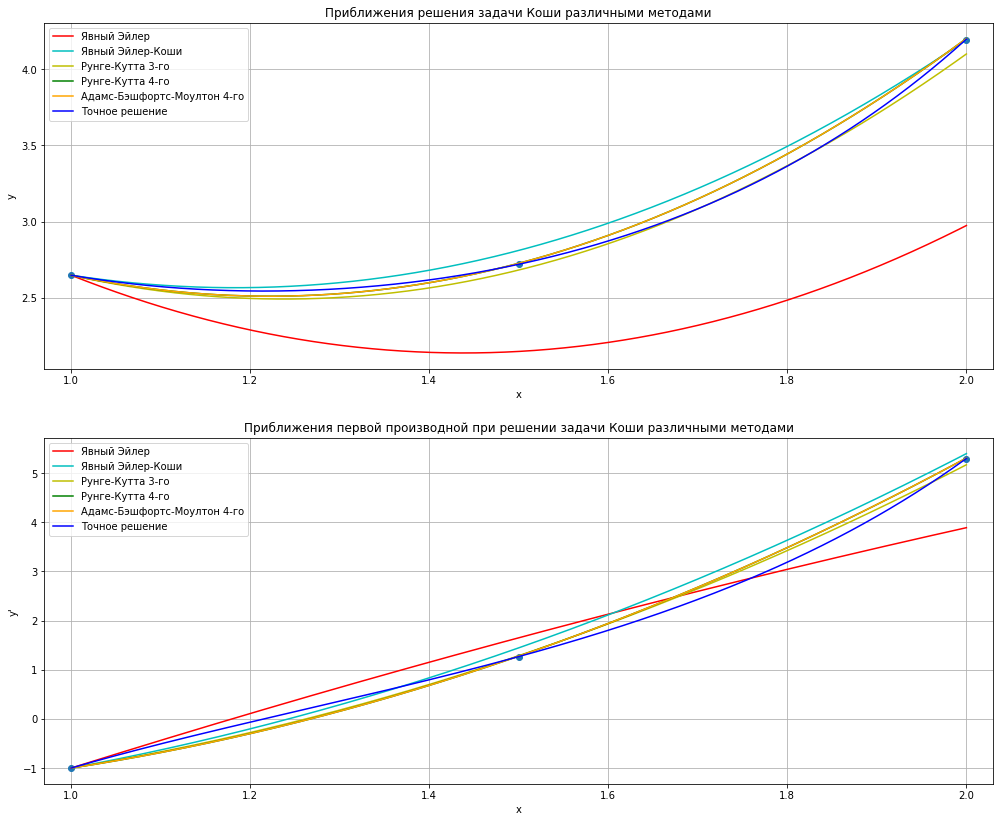

In [40]:
a = 1
b = 2
h = 0.5
y0 = 1 + math.exp(1/2)
z0 = -1

xp = compute_x(a, b, h)
xi = compute_x(a, b, 0.0005)

yp1, zp1 = explict_eiler(xp, y0, z0, h)
Ly = lagrange_func(xp, yp1)
Lz = lagrange_func(xp, zp1)
y1 = list(map(Ly, xi))
z1 = list(map(Lz, xi))

yp2, zp2 = explict_eiler_koshi(xp, y0, z0, h)
Ly = lagrange_func(xp, yp2)
Lz = lagrange_func(xp, zp2)
y2 = list(map(Ly, xi))
z2 = list(map(Lz, xi))

yp3, zp3 = runge_kutta_3p(xp, y0, z0, h)
Ly = lagrange_func(xp, yp3)
Lz = lagrange_func(xp, zp3)
y3 = list(map(Ly, xi))
z3 = list(map(Lz, xi))

yp4, zp4 = runge_kutta_4p(xp, y0, z0, h)
Ly = lagrange_func(xp, yp4)
Lz = lagrange_func(xp, zp4)
y4 = list(map(Ly, xi))
z4 = list(map(Lz, xi))

yp5, zp5 = adams_boult_method(xp, y0, z0, h)
Ly = lagrange_func(xp, yp5)
Lz = lagrange_func(xp, zp5)
y5 = list(map(Ly, xi))
z5 = list(map(Lz, xi))

y6 = list(map(y_x, xi))
z6 = list(map(dy_dx_x, xi))

yp = list(map(y_x, xp))
zp = list(map(dy_dx_x, xp))


fig = plt.figure(figsize=(17, 14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(xp, yp, 'o')

line1, = ax1.plot(xi, y1, 'r')
line2, = ax1.plot(xi, y2, 'c')
line3, = ax1.plot(xi, y3, 'y')
line4, = ax1.plot(xi, y4, 'g')
line5, = ax1.plot(xi, y5, 'orange')
line6, = ax1.plot(xi, y6, 'b')




ax1.set_xlabel('x')
ax1.set_ylabel('y')


# set title, plot limits, etc
ax1.set_title('Приближения решения задачи Коши различными методами')
ax1.set_xlim(0.97, 2.03)



ax1.legend((line1, line2, line3, line4, line5, line6), 
           ("Явный Эйлер", "Явный Эйлер-Коши", "Рунге-Кутта 3-го", "Рунге-Кутта 4-го", 
            "Адамс-Бэшфортс-Моултон 4-го", "Точное решение"))
ax1.grid()

ax2.plot(xp, zp, 'o')

line7, = ax2.plot(xi, z1, 'r')
line8, = ax2.plot(xi, z2, 'c')
line9, = ax2.plot(xi, z3, 'y')
line10, = ax2.plot(xi, z4, 'g')
line11, = ax2.plot(xi, z5, 'orange')
line12, = ax2.plot(xi, z6, 'b')


ax2.set_xlabel('x')
ax2.set_ylabel("y'")


# set title, plot limits, etc
ax2.set_title('Приближения первой производной при решении задачи Коши различными методами')
ax2.set_xlim(0.97, 2.03)



ax2.legend((line7, line8, line9, line10, line11, line12), 
           ("Явный Эйлер", "Явный Эйлер-Коши", "Рунге-Кутта 3-го", "Рунге-Кутта 4-го", 
            "Адамс-Бэшфортс-Моултон 4-го", "Точное решение"))
ax2.grid()


plt.show()

In [41]:
def epsilon_by_h(y0, z0, h, a, b, met):
    xi = compute_x(a, b, h)
    y = met(xi, y0, z0, h)[0]
    return epsilon(xi, y)

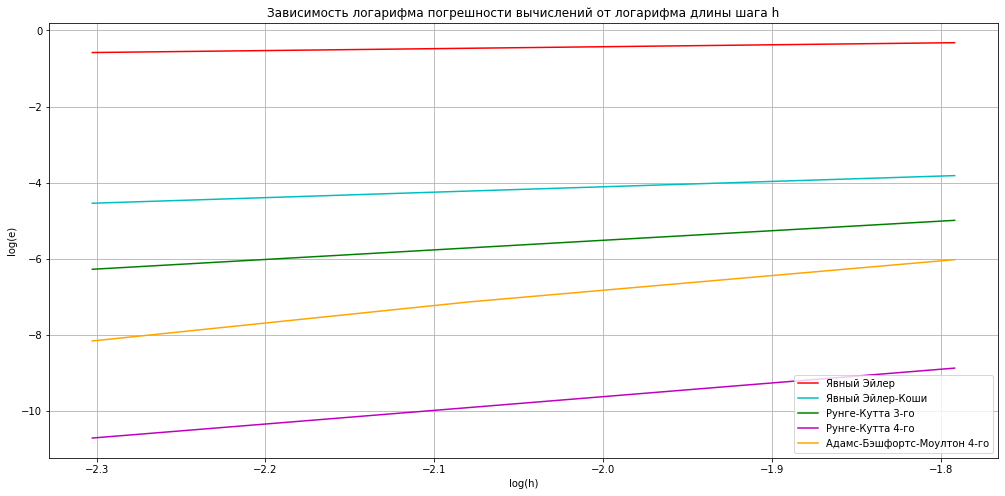

In [42]:
hi = [(b - a) / i for i in range(6, 12, 2)]

hh = list(map(math.log, hi))

y1 = list(map(lambda v: math.log(epsilon_by_h(y0, z0, v, a, b, explict_eiler)), hi))
y2 = list(map(lambda v: math.log(epsilon_by_h(y0, z0, v, a, b, explict_eiler_koshi)), hi))
y3 = list(map(lambda v: math.log(epsilon_by_h(y0, z0, v, a, b, runge_kutta_3p)), hi))
y4 = list(map(lambda v: math.log(epsilon_by_h(y0, z0, v, a, b, runge_kutta_4p)), hi))
y5 = list(map(lambda v: math.log(epsilon_by_h(y0, z0, v, a, b, adams_boult_method)), hi))


fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(111)

line1, = ax1.plot(hh, y1, 'r')
line2, = ax1.plot(hh, y2, 'c')
line3, = ax1.plot(hh, y3, 'g')
line4, = ax1.plot(hh, y4, 'm')
line5, = ax1.plot(hh, y5, 'orange')

ax1.set_xlabel('log(h)')
ax1.set_ylabel('log(e)')


# set title, plot limits, etc
plt.title('Зависимость логарифма погрешности вычислений от логарифма длины шага h')



ax1.legend((line1, line2, line3, line4, line5), 
           ("Явный Эйлер", "Явный Эйлер-Коши", "Рунге-Кутта 3-го", "Рунге-Кутта 4-го", 
            "Адамс-Бэшфортс-Моултон 4-го"))

plt.grid()

plt.show()

###### <center>Сделано Бронниковым Максимом</center>
###### <center>18.04.2020</center>